In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import *
from keras.optimizers import Adam
from statistics import mean
import os
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.linewidth'] = 1.5

Using TensorFlow backend.


In [4]:
np.random.seed(7)

In [5]:
df = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Ford 5 years.csv', header=0, index_col=0)
dataframe_ford = df
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-15,15.27,15.49,15.27,15.48,11.977631,18937700
2015-05-18,15.47,15.64,15.45,15.58,12.055005,19491900
2015-05-19,15.59,15.63,15.45,15.50,11.993106,15145300
2015-05-20,15.54,15.56,15.26,15.30,11.838357,22391500
2015-05-21,15.28,15.55,15.26,15.51,12.000844,23962000
...,...,...,...,...,...,...
2020-05-08,4.96,5.25,4.95,5.24,5.240000,101333800
2020-05-11,5.18,5.19,5.05,5.12,5.120000,75593900
2020-05-12,5.15,5.22,4.97,4.98,4.980000,70965200


In [252]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(dataframe_ford['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    return data,scaler_high
    

In [253]:
df,scaler = normalize(df)

In [254]:
#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values

print('Xarr:',Xarr[0:5])
print('yarr:',yarr[0:5])
print('Datearr:',Datearr[0:5])

yarr = np.delete(yarr, 0)
print('yarr:',yarr[0:5])
print('X shape:',Xarr.shape)
print('y shape:',yarr.shape)

Xarr: [[0.95986038 0.96935201 0.97416021 0.98286204 0.96620093 0.04988881]
 [0.97731239 0.98248687 0.98966408 0.99143102 0.97558374 0.05236248]
 [0.9877836  0.98161121 0.98966408 0.98457584 0.96807751 0.0329615 ]
 [0.98342059 0.97548161 0.97329888 0.96743787 0.94931176 0.0653048 ]
 [0.96073298 0.97460595 0.97329888 0.98543273 0.96901587 0.0723147 ]]
yarr: [[0.96935201]
 [0.98248687]
 [0.98161121]
 [0.97548161]
 [0.97460595]]
Datearr: ['2015-05-15' '2015-05-18' '2015-05-19' '2015-05-20' '2015-05-21']
yarr: [0.98248687 0.98161121 0.97548161 0.97460595 0.97022767]
X shape: (1258, 6)
y shape: (1258,)


In [233]:
def build_data(start,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+1]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+1]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+1]
    return X_train,X_test,y_train,y_test,Date_train,Date_test


#X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0)

trn_size = len(Xarr)
#print(X_train.shape,X_test.shape)
#print(y_train.shape,y_test.shape)
#print(Date_train.shape,Date_test.shape)

In [1]:
# univariate mlp example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model = tf.keras.models.Sequential()
    
model.add(tf.keras.layers.Reshape((6,),input_shape=(6,)))
    
    #model.add(tf.keras.layers.BatchNormalization())
    
model.add(tf.keras.layers.Dense(params['first_size'],activation='relu'))
    
model.add(tf.keras.layers.Dense(1,activation='linear'))
    
    #optimize = tf.keras.optimizers.Adam(lr=0.03,decay = 0.001)
    
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

Using TensorFlow backend.


NameError: name 'ModelCheckpoint' is not defined

In [ ]:
model.summary()

In [29]:
import time
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    
    predicted_high.append(yhat[0])
    predicted_dates.append(Date_test[0])
    actual_high.append(y_test[0])
    model_loss.append(history.history['loss'][-1])
    model_val_loss.append(history.history['val_loss'][-1])
    
time_taken = time.time() - start_time

0
Epoch 00012: early stopping
1
Epoch 00089: early stopping
2
Epoch 00011: early stopping
3
Epoch 00013: early stopping
4
Epoch 00011: early stopping
5
Epoch 00011: early stopping
6
Epoch 00013: early stopping
7
Epoch 00011: early stopping
8
Epoch 00011: early stopping
9
Epoch 00013: early stopping
10
Epoch 00011: early stopping
11
Epoch 00011: early stopping
12
Epoch 00011: early stopping
13
Epoch 00012: early stopping
14
Epoch 00011: early stopping
15
Epoch 00011: early stopping
16
Epoch 00011: early stopping
17
Epoch 00011: early stopping
18
Epoch 00012: early stopping
19
Epoch 00011: early stopping
20
Epoch 00012: early stopping
21
Epoch 00011: early stopping
22
Epoch 00011: early stopping
23
Epoch 00015: early stopping
24
Epoch 00014: early stopping
25
Epoch 00014: early stopping
26
Epoch 00011: early stopping
27
Epoch 00012: early stopping
28
Epoch 00013: early stopping
29
Epoch 00013: early stopping
30
Epoch 00013: early stopping
31
Epoch 00011: early stopping
32
Epoch 00011: ea

Epoch 00011: early stopping
264
Epoch 00011: early stopping
265
Epoch 00018: early stopping
266
Epoch 00014: early stopping
267
Epoch 00193: early stopping
268
Epoch 00045: early stopping
269
Epoch 00012: early stopping
270
Epoch 00012: early stopping
271
Epoch 00014: early stopping
272
Epoch 00011: early stopping
273
Epoch 00011: early stopping
274
Epoch 00011: early stopping
275
Epoch 00071: early stopping
276
277
Epoch 00012: early stopping
278
Epoch 00011: early stopping
279
Epoch 00059: early stopping
280
Epoch 00011: early stopping
281
Epoch 00014: early stopping
282
Epoch 00011: early stopping
283
Epoch 00012: early stopping
284
Epoch 00012: early stopping
285
Epoch 00011: early stopping
286
Epoch 00012: early stopping
287
Epoch 00012: early stopping
288
Epoch 00012: early stopping
289
Epoch 00121: early stopping
290
Epoch 00012: early stopping
291
Epoch 00013: early stopping
292
Epoch 00012: early stopping
293
Epoch 00012: early stopping
294
Epoch 00011: early stopping
295
Epoc

Epoch 00018: early stopping
523
Epoch 00013: early stopping
524
Epoch 00014: early stopping
525
Epoch 00018: early stopping
526
Epoch 00014: early stopping
527
Epoch 00018: early stopping
528
Epoch 00014: early stopping
529
Epoch 00019: early stopping
530
Epoch 00014: early stopping
531
Epoch 00011: early stopping
532
Epoch 00016: early stopping
533
Epoch 00015: early stopping
534
Epoch 00014: early stopping
535
Epoch 00015: early stopping
536
Epoch 00016: early stopping
537
Epoch 00019: early stopping
538
Epoch 00014: early stopping
539
Epoch 00016: early stopping
540
Epoch 00011: early stopping
541
Epoch 00011: early stopping
542
Epoch 00011: early stopping
543
Epoch 00011: early stopping
544
Epoch 00037: early stopping
545
Epoch 00013: early stopping
546
Epoch 00011: early stopping
547
Epoch 00013: early stopping
548
Epoch 00012: early stopping
549
Epoch 00011: early stopping
550
Epoch 00011: early stopping
551
Epoch 00013: early stopping
552
Epoch 00015: early stopping
553
Epoch 00

Epoch 00023: early stopping
780
Epoch 00012: early stopping
781
Epoch 00013: early stopping
782
Epoch 00013: early stopping
783
Epoch 00012: early stopping
784
Epoch 00012: early stopping
785
Epoch 00012: early stopping
786
Epoch 00013: early stopping
787
Epoch 00011: early stopping
788
Epoch 00016: early stopping
789
Epoch 00012: early stopping
790
Epoch 00013: early stopping
791
Epoch 00013: early stopping
792
Epoch 00013: early stopping
793
Epoch 00013: early stopping
794
Epoch 00073: early stopping
795
Epoch 00019: early stopping
796
Epoch 00012: early stopping
797
Epoch 00015: early stopping
798
Epoch 00011: early stopping
799
Epoch 00015: early stopping
800
Epoch 00021: early stopping
801
Epoch 00011: early stopping
802
Epoch 00011: early stopping
803
Epoch 00014: early stopping
804
Epoch 00012: early stopping
805
Epoch 00013: early stopping
806
Epoch 00022: early stopping
807
Epoch 00012: early stopping
808
Epoch 00011: early stopping
809
Epoch 00060: early stopping
810
Epoch 00

Epoch 00020: early stopping
1036
Epoch 00012: early stopping
1037
Epoch 00015: early stopping
1038
Epoch 00012: early stopping
1039
Epoch 00011: early stopping
1040
Epoch 00015: early stopping
1041
Epoch 00011: early stopping
1042
Epoch 00067: early stopping
1043
Epoch 00011: early stopping
1044
Epoch 00011: early stopping
1045
Epoch 00059: early stopping
1046
Epoch 00017: early stopping
1047
Epoch 00018: early stopping
1048
Epoch 00012: early stopping
1049
Epoch 00014: early stopping
1050
Epoch 00025: early stopping
1051
Epoch 00011: early stopping
1052
Epoch 00023: early stopping
1053
Epoch 00012: early stopping
1054
Epoch 00019: early stopping
1055
Epoch 00031: early stopping
1056
Epoch 00012: early stopping
1057
Epoch 00011: early stopping


time taken for execution : 264.0629246234894 seconds 


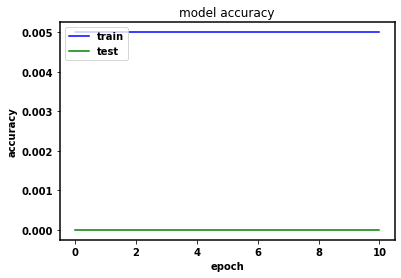

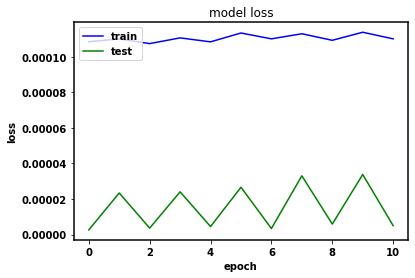

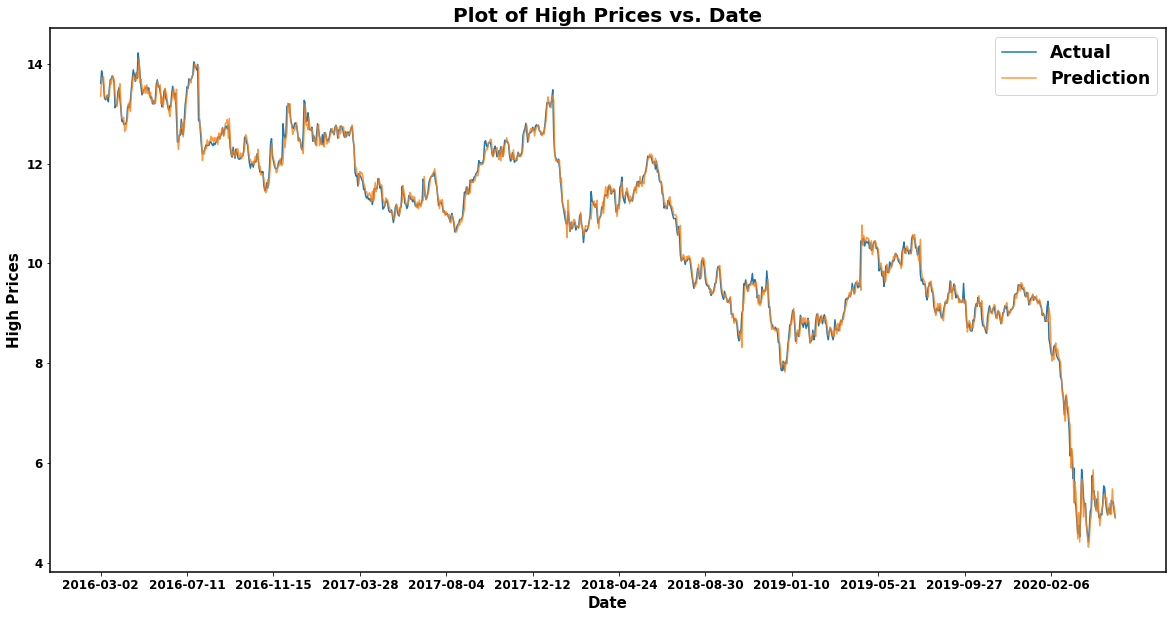

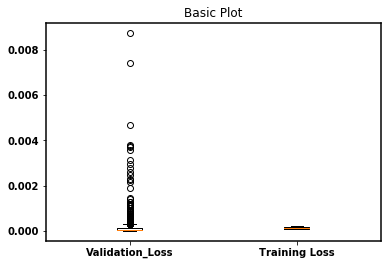

In [147]:
#print(history.history.keys())
print("time taken for execution : %s seconds " % (time_taken))
plt.plot(history.history['accuracy'],color="blue")
plt.plot(history.history['val_accuracy'],color="green")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],color="blue")
plt.plot(history.history['val_loss'],color="green")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
        
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('Plot of High Prices vs. Date',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    data = [model_val_loss,model_loss]
    ax1.boxplot(data,labels = ['Validation_Loss','Training Loss'])
    #plt.set_title('Distribution of Loss',fontsize=20,fontweight='bold')
    #plt.ylabel('Loss',fontsize=15)
    #plt.figure(figsize=(20,10))
    #plt.boxplot()

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))



# Error In Prediction:

Mean Validation loss= 0.00015815
Mean Model loss= 0.00013023
   39     0.001878 2016-04-27            13.725059       14.220000
   79     0.002588 2016-06-23            13.490980       12.910000
  102     0.008762 2016-07-27            13.928982       12.860000
  190     0.004696 2016-11-30            12.017408       12.800000
  194     0.002161 2016-12-06            12.619165       13.150000
  211     0.001201 2016-12-30            12.204317       12.600000
  212     0.002279 2017-01-03            12.724865       13.270000
  336     0.001398 2017-06-30            11.263062       11.690000
  472     0.003733 2018-01-16            13.277750       12.580000
  511     0.002259 2018-03-13            10.897211       11.440000
  604     0.002790 2018-07-25            10.763224       10.160000
  668     0.003586 2018-10-24             8.316132        9.000000
  670     0.001195 2018-10-26             9.195205        9.590000
  694     0.001101 2018-11-30             9.471066        9.850000
 

<BarContainer object of 30 artists>

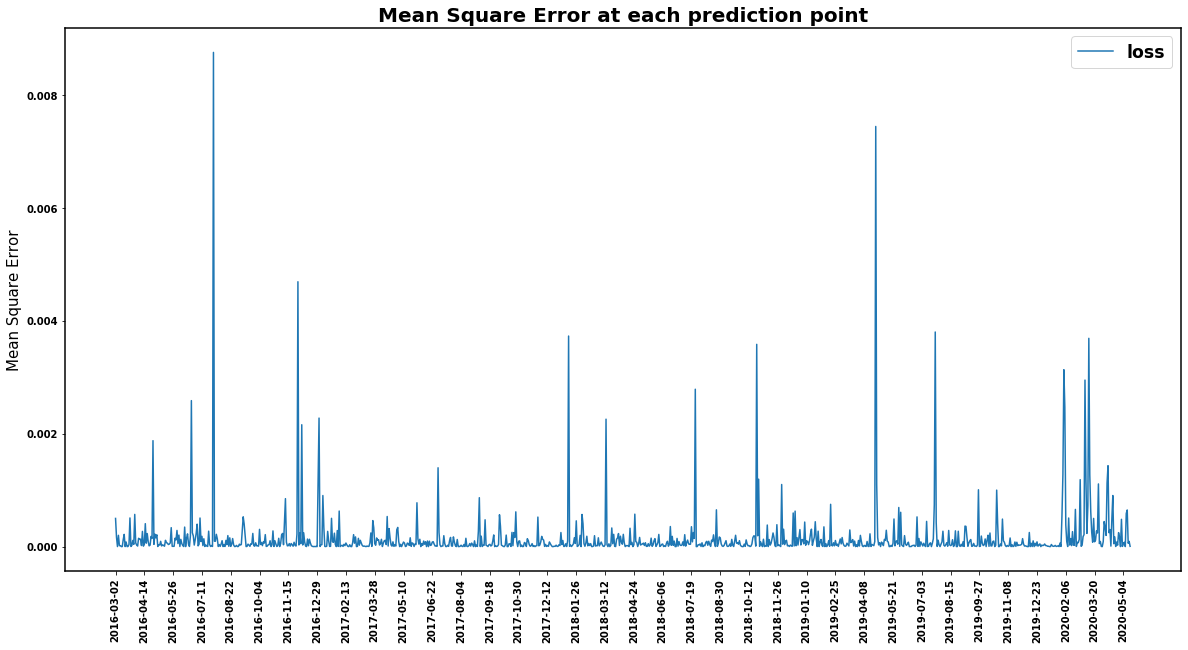

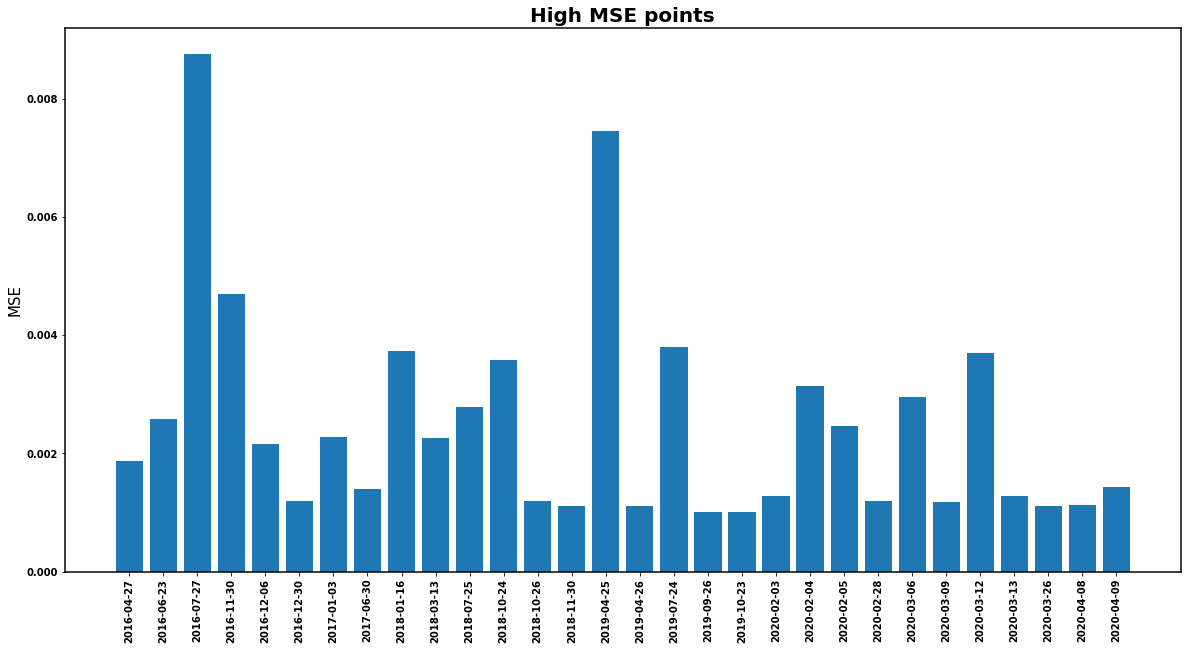

In [193]:
def mae(y_predicted,y_actual,dates):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append((abs(y_predicted[i] - y_actual[i]))**2)
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title('Mean Square Error at each prediction point',fontsize=20,fontweight='bold')
    plt.ylabel('Mean Square Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

mae(predicted_high,actual_high,np.array(predicted_dates))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))

large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)


In [23]:
print('Predicted Range:',predicted_dates[0],predicted_dates[len(predicted_dates)-1])

Predicted Range: 2016-03-02 2020-05-13


# CNN Model:

In [210]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 5, 64)             192       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 2, 64)             0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 51        
Total params: 6,693
Trainable params: 6,693
Non-trainable params: 0
_________________________________________________________________


In [222]:
import time
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    
    predicted_high.append(yhat[0])
    predicted_dates.append(Date_test[0])
    actual_high.append(y_test[0])
    model_loss.append(history.history['loss'][-1])
    model_val_loss.append(history.history['val_loss'][-1])
    
time_taken = time.time() - start_time


0
Epoch 00014: early stopping
1
Epoch 00028: early stopping
2
Epoch 00018: early stopping
3
Epoch 00013: early stopping
4
Epoch 00012: early stopping
5
Epoch 00012: early stopping
6
Epoch 00020: early stopping
7
Epoch 00011: early stopping
8
Epoch 00028: early stopping
9
Epoch 00014: early stopping
10
Epoch 00045: early stopping
11
Epoch 00013: early stopping
12
Epoch 00013: early stopping
13
Epoch 00011: early stopping
14
Epoch 00011: early stopping
15
Epoch 00011: early stopping
16
Epoch 00011: early stopping
17
Epoch 00014: early stopping
18
Epoch 00012: early stopping
19
Epoch 00024: early stopping
20
Epoch 00016: early stopping
21
Epoch 00011: early stopping
22
Epoch 00023: early stopping
23
Epoch 00013: early stopping
24
Epoch 00013: early stopping
25
Epoch 00012: early stopping
26
Epoch 00015: early stopping
27
Epoch 00021: early stopping
28
Epoch 00014: early stopping
29
Epoch 00013: early stopping
30
Epoch 00011: early stopping
31
Epoch 00014: early stopping
32
Epoch 00033: ea

Epoch 00030: early stopping
273
Epoch 00011: early stopping
274
Epoch 00013: early stopping
275
Epoch 00041: early stopping
276
Epoch 00012: early stopping
277
Epoch 00037: early stopping
278
Epoch 00030: early stopping
279
Epoch 00022: early stopping
280
Epoch 00033: early stopping
281
Epoch 00022: early stopping
282
Epoch 00011: early stopping
283
Epoch 00011: early stopping
284
Epoch 00011: early stopping
285
Epoch 00034: early stopping
286
Epoch 00018: early stopping
287
Epoch 00038: early stopping
288
Epoch 00011: early stopping
289
Epoch 00015: early stopping
290
Epoch 00055: early stopping
291
Epoch 00011: early stopping
292
Epoch 00033: early stopping
293
Epoch 00026: early stopping
294
Epoch 00016: early stopping
295
Epoch 00027: early stopping
296
Epoch 00015: early stopping
297
Epoch 00012: early stopping
298
Epoch 00011: early stopping
299
Epoch 00013: early stopping
300
Epoch 00013: early stopping
301
Epoch 00037: early stopping
302
Epoch 00020: early stopping
303
Epoch 00

Epoch 00023: early stopping
532
Epoch 00023: early stopping
533
Epoch 00011: early stopping
534
Epoch 00019: early stopping
535
Epoch 00028: early stopping
536
Epoch 00015: early stopping
537
Epoch 00015: early stopping
538
Epoch 00015: early stopping
539
Epoch 00018: early stopping
540
Epoch 00011: early stopping
541
Epoch 00012: early stopping
542
Epoch 00015: early stopping
543
Epoch 00022: early stopping
544
Epoch 00014: early stopping
545
Epoch 00013: early stopping
546
Epoch 00011: early stopping
547
Epoch 00013: early stopping
548
Epoch 00013: early stopping
549
Epoch 00011: early stopping
550
Epoch 00016: early stopping
551
Epoch 00014: early stopping
552
Epoch 00020: early stopping
553
Epoch 00031: early stopping
554
Epoch 00014: early stopping
555
Epoch 00012: early stopping
556
Epoch 00035: early stopping
557
Epoch 00043: early stopping
558
Epoch 00036: early stopping
559
Epoch 00020: early stopping
560
Epoch 00044: early stopping
561
Epoch 00013: early stopping
562
Epoch 00

Epoch 00079: early stopping
790
Epoch 00012: early stopping
791
Epoch 00013: early stopping
792
Epoch 00012: early stopping
793
794
795
Epoch 00018: early stopping
796
Epoch 00012: early stopping
797
Epoch 00011: early stopping
798
Epoch 00012: early stopping
799
Epoch 00011: early stopping
800
Epoch 00012: early stopping
801
Epoch 00014: early stopping
802
Epoch 00012: early stopping
803
Epoch 00012: early stopping
804
Epoch 00012: early stopping
805
Epoch 00013: early stopping
806
Epoch 00023: early stopping
807
Epoch 00019: early stopping
808
Epoch 00014: early stopping
809
Epoch 00014: early stopping
810
Epoch 00016: early stopping
811
Epoch 00031: early stopping
812
Epoch 00030: early stopping
813
Epoch 00017: early stopping
814
Epoch 00020: early stopping
815
Epoch 00015: early stopping
816
Epoch 00024: early stopping
817
Epoch 00014: early stopping
818
Epoch 00012: early stopping
819
Epoch 00012: early stopping
820
Epoch 00012: early stopping
821
Epoch 00034: early stopping
822


Epoch 00021: early stopping
1050
Epoch 00025: early stopping
1051
Epoch 00019: early stopping
1052
Epoch 00022: early stopping
1053
Epoch 00015: early stopping
1054
Epoch 00012: early stopping
1055
Epoch 00013: early stopping
1056
Epoch 00011: early stopping
1057
Epoch 00012: early stopping


time taken for execution : 116.36507606506348 seconds 


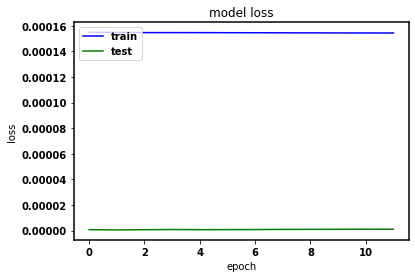

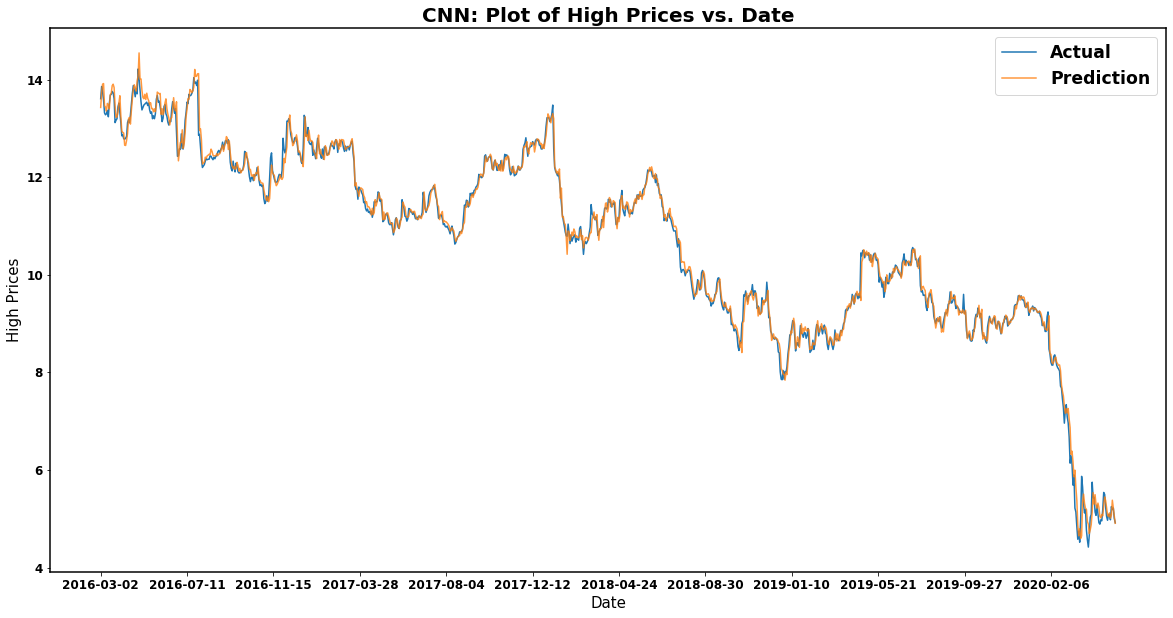

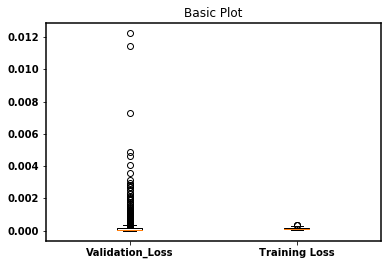

In [224]:

print("time taken for execution : %s seconds " % (time_taken))
# summarize history for loss
plt.plot(history.history['loss'],color="blue")
plt.plot(history.history['val_loss'],color="green")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
        
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('CNN: Plot of High Prices vs. Date',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    data = [model_val_loss,model_loss]
    ax1.boxplot(data,labels = ['Validation_Loss','Training Loss'])

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

Mean Validation loss= 0.00048754
Mean Model loss= 0.00021971
  119     0.001684 2016-03-02            13.141427       13.610000
  148     0.001320 2016-03-02            13.195157       13.610000
  162     0.001087 2016-03-02            13.233481       13.610000
  170     0.001769 2016-03-02            13.129712       13.610000
  175     0.001083 2016-03-02            13.234099       13.610000
  197     0.001031 2016-03-02            13.243316       13.610000
  205     0.001326 2016-03-02            13.194155       13.610000
  245     0.001166 2016-03-02            13.219976       13.610000
  252     0.001249 2016-03-02            13.206347       13.610000
  288     0.001277 2016-03-02            13.201974       13.610000
  302     0.001636 2016-03-02            13.148153       13.610000
  354     0.001043 2016-03-02            13.241252       13.610000
  362     0.001069 2016-03-02            13.236664       13.610000
  425     0.001062 2016-03-02            13.237895       13.610000
 

<BarContainer object of 15 artists>

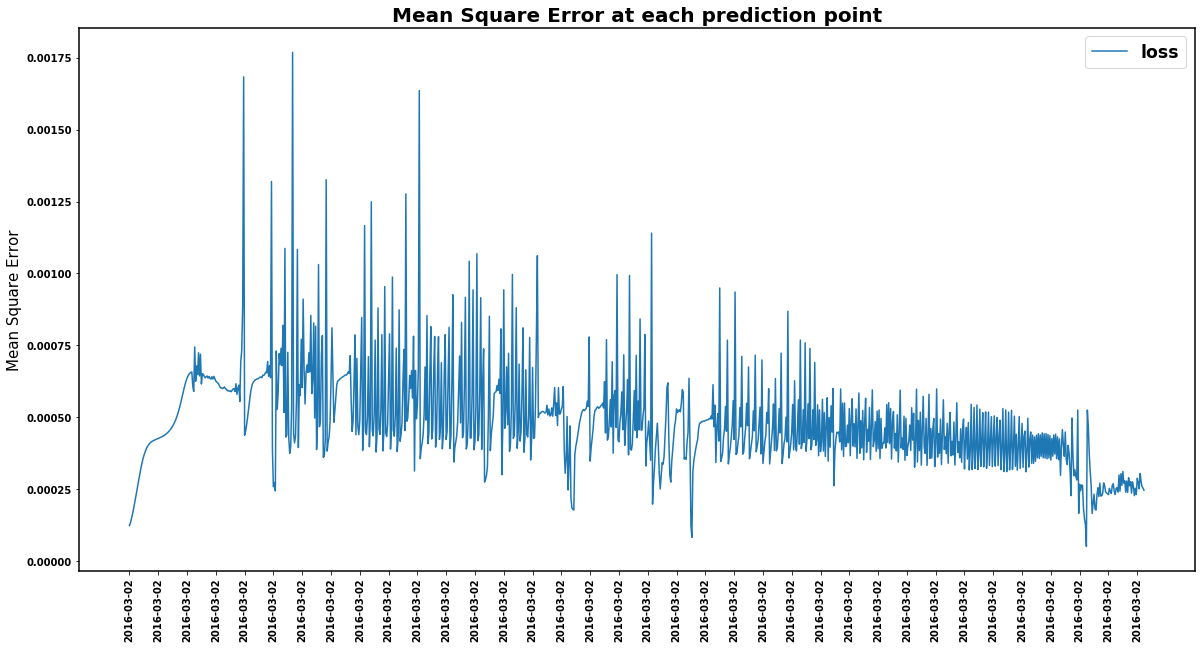

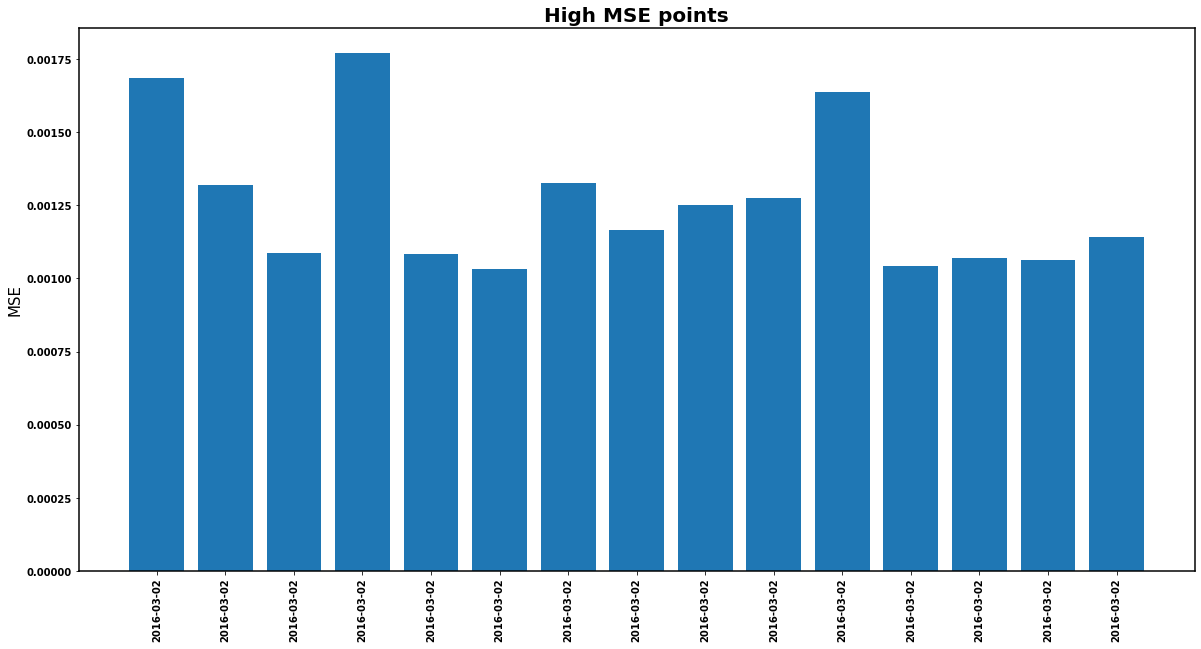

In [214]:
def mae(y_predicted,y_actual,dates):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append((abs(y_predicted[i] - y_actual[i]))**2)
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title('Mean Square Error at each prediction point',fontsize=20,fontweight='bold')
    plt.ylabel('Mean Square Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

mae(predicted_high,actual_high,np.array(predicted_dates))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))

large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# LSTM:

In [238]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)

In [239]:
import time
start_time = time.time()

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    
    predicted_high.append(yhat[0])
    predicted_dates.append(Date_test[0])
    actual_high.append(y_test[0])
    model_loss.append(history.history['loss'][-1])
    model_val_loss.append(history.history['val_loss'][-1])
    
time_taken = time.time() - start_time

0
Epoch 00030: early stopping
1
Epoch 00011: early stopping
2
Epoch 00078: early stopping
3
Epoch 00061: early stopping
4
Epoch 00011: early stopping
5
Epoch 00015: early stopping
6
Epoch 00011: early stopping
7
Epoch 00016: early stopping
8
Epoch 00011: early stopping
9
Epoch 00017: early stopping
10
Epoch 00015: early stopping
11
Epoch 00012: early stopping
12
Epoch 00012: early stopping
13
Epoch 00011: early stopping
14
15
Epoch 00012: early stopping
16
Epoch 00017: early stopping
17
Epoch 00012: early stopping
18
Epoch 00015: early stopping
19
Epoch 00012: early stopping
20
Epoch 00017: early stopping
21
Epoch 00012: early stopping
22
Epoch 00012: early stopping
23
Epoch 00018: early stopping
24
Epoch 00012: early stopping
25
Epoch 00016: early stopping
26
Epoch 00015: early stopping
27
Epoch 00018: early stopping
28
Epoch 00018: early stopping
29
Epoch 00012: early stopping
30
Epoch 00015: early stopping
31
Epoch 00011: early stopping
32
Epoch 00032: early stopping
33
Epoch 00019:

Epoch 00024: early stopping
263
Epoch 00017: early stopping
264
Epoch 00011: early stopping
265
Epoch 00016: early stopping
266
Epoch 00016: early stopping
267
Epoch 00052: early stopping
268
Epoch 00021: early stopping
269
Epoch 00013: early stopping
270
Epoch 00013: early stopping
271
Epoch 00011: early stopping
272
Epoch 00016: early stopping
273
Epoch 00016: early stopping
274
Epoch 00011: early stopping
275
Epoch 00017: early stopping
276
Epoch 00015: early stopping
277
Epoch 00014: early stopping
278
Epoch 00011: early stopping
279
Epoch 00014: early stopping
280
Epoch 00012: early stopping
281
Epoch 00013: early stopping
282
Epoch 00011: early stopping
283
Epoch 00014: early stopping
284
Epoch 00011: early stopping
285
Epoch 00022: early stopping
286
Epoch 00011: early stopping
287
Epoch 00014: early stopping
288
Epoch 00015: early stopping
289
Epoch 00014: early stopping
290
Epoch 00015: early stopping
291
Epoch 00022: early stopping
292
Epoch 00012: early stopping
293
Epoch 00

Epoch 00011: early stopping
520
Epoch 00019: early stopping
521
Epoch 00012: early stopping
522
Epoch 00012: early stopping
523
Epoch 00035: early stopping
524
Epoch 00011: early stopping
525
Epoch 00040: early stopping
526
Epoch 00029: early stopping
527
Epoch 00013: early stopping
528
Epoch 00018: early stopping
529
Epoch 00020: early stopping
530
Epoch 00012: early stopping
531
Epoch 00018: early stopping
532
Epoch 00022: early stopping
533
Epoch 00012: early stopping
534
Epoch 00013: early stopping
535
Epoch 00011: early stopping
536
Epoch 00020: early stopping
537
Epoch 00017: early stopping
538
Epoch 00022: early stopping
539
Epoch 00013: early stopping
540
Epoch 00034: early stopping
541
Epoch 00030: early stopping
542
Epoch 00020: early stopping
543
Epoch 00013: early stopping
544
Epoch 00012: early stopping
545
Epoch 00016: early stopping
546
Epoch 00013: early stopping
547
Epoch 00011: early stopping
548
Epoch 00028: early stopping
549
Epoch 00013: early stopping
550
Epoch 00

Epoch 00013: early stopping
778
Epoch 00011: early stopping
779
Epoch 00034: early stopping
780
Epoch 00013: early stopping
781
Epoch 00014: early stopping
782
Epoch 00023: early stopping
783
Epoch 00025: early stopping
784
Epoch 00033: early stopping
785
Epoch 00023: early stopping
786
Epoch 00016: early stopping
787
Epoch 00025: early stopping
788
Epoch 00017: early stopping
789
Epoch 00013: early stopping
790
Epoch 00015: early stopping
791
Epoch 00039: early stopping
792
Epoch 00029: early stopping
793
Epoch 00013: early stopping
794
Epoch 00011: early stopping
795
Epoch 00020: early stopping
796
Epoch 00013: early stopping
797
Epoch 00013: early stopping
798
Epoch 00082: early stopping
799
Epoch 00013: early stopping
800
Epoch 00023: early stopping
801
Epoch 00013: early stopping
802
Epoch 00023: early stopping
803
Epoch 00030: early stopping
804
Epoch 00013: early stopping
805
Epoch 00029: early stopping
806
Epoch 00012: early stopping
807
Epoch 00018: early stopping
808
Epoch 00

Epoch 00013: early stopping
1033
1034
Epoch 00025: early stopping
1035
Epoch 00016: early stopping
1036
Epoch 00012: early stopping
1037
Epoch 00016: early stopping
1038
Epoch 00011: early stopping
1039
Epoch 00011: early stopping
1040
Epoch 00025: early stopping
1041
Epoch 00020: early stopping
1042
Epoch 00016: early stopping
1043
Epoch 00013: early stopping
1044
Epoch 00029: early stopping
1045
Epoch 00012: early stopping
1046
Epoch 00028: early stopping
1047
Epoch 00019: early stopping
1048
Epoch 00024: early stopping
1049
Epoch 00014: early stopping
1050
Epoch 00013: early stopping
1051
Epoch 00017: early stopping
1052
Epoch 00014: early stopping
1053
Epoch 00011: early stopping
1054
Epoch 00017: early stopping
1055
Epoch 00036: early stopping
1056
Epoch 00017: early stopping
1057
Epoch 00011: early stopping


time taken for execution : 569.0052609443665 seconds 


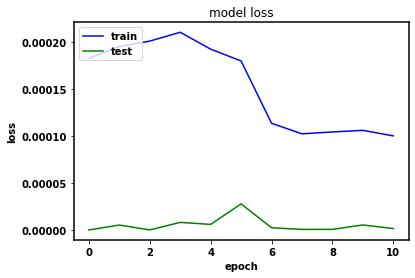

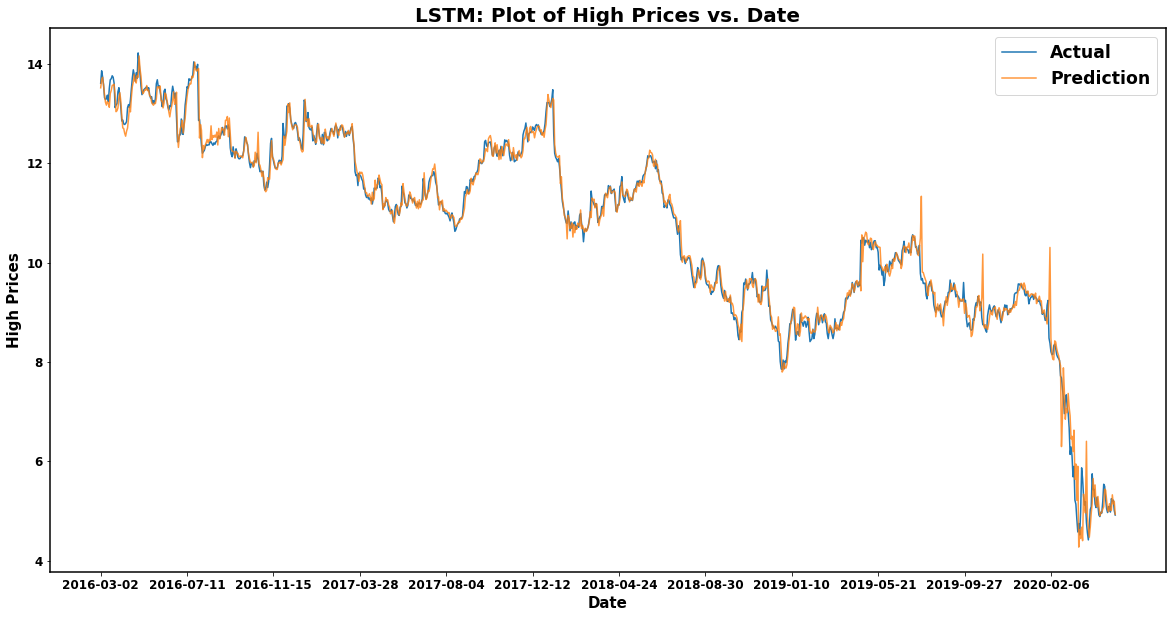

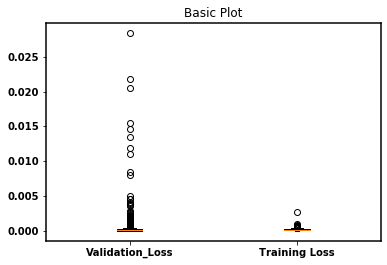

In [247]:
print("time taken for execution : %s seconds " % (time_taken))
# summarize history for loss
plt.plot(history.history['loss'],color="blue")
plt.plot(history.history['val_loss'],color="green")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
        
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('LSTM: Plot of High Prices vs. Date',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    plt.savefig("LSTM.pdf")
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    data = [model_val_loss,model_loss]
    ax1.boxplot(data,labels = ['Validation_Loss','Training Loss'])

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

Mean Validation loss= 0.00034176
Mean Model loss= 0.00015369


<BarContainer object of 54 artists>

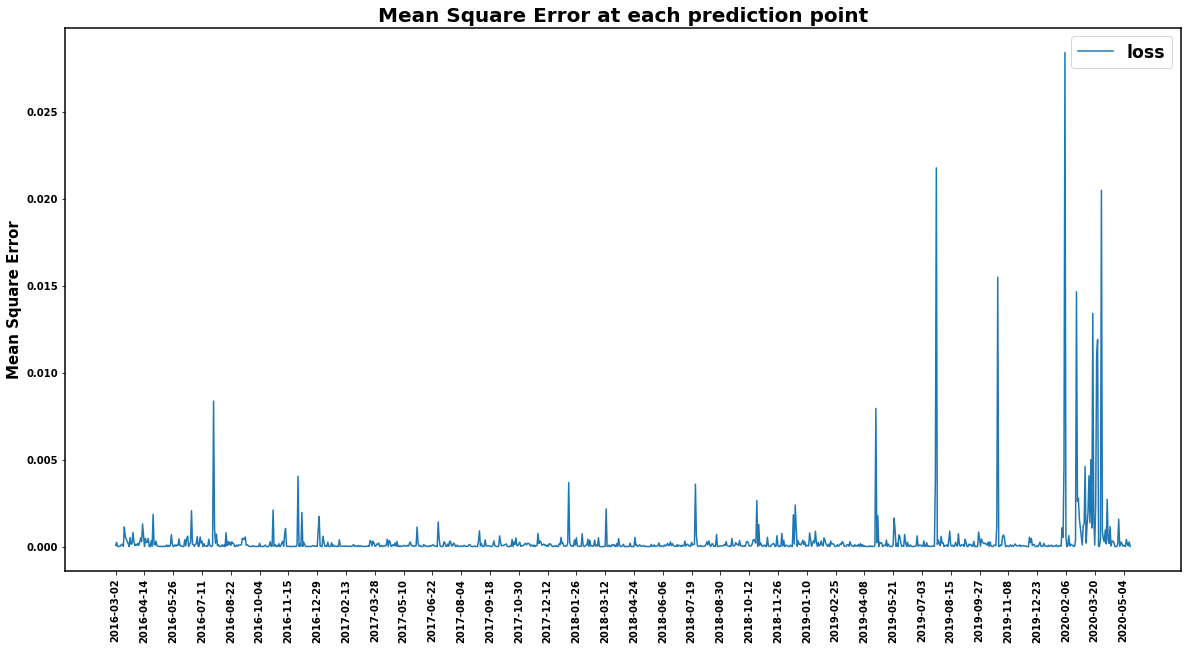

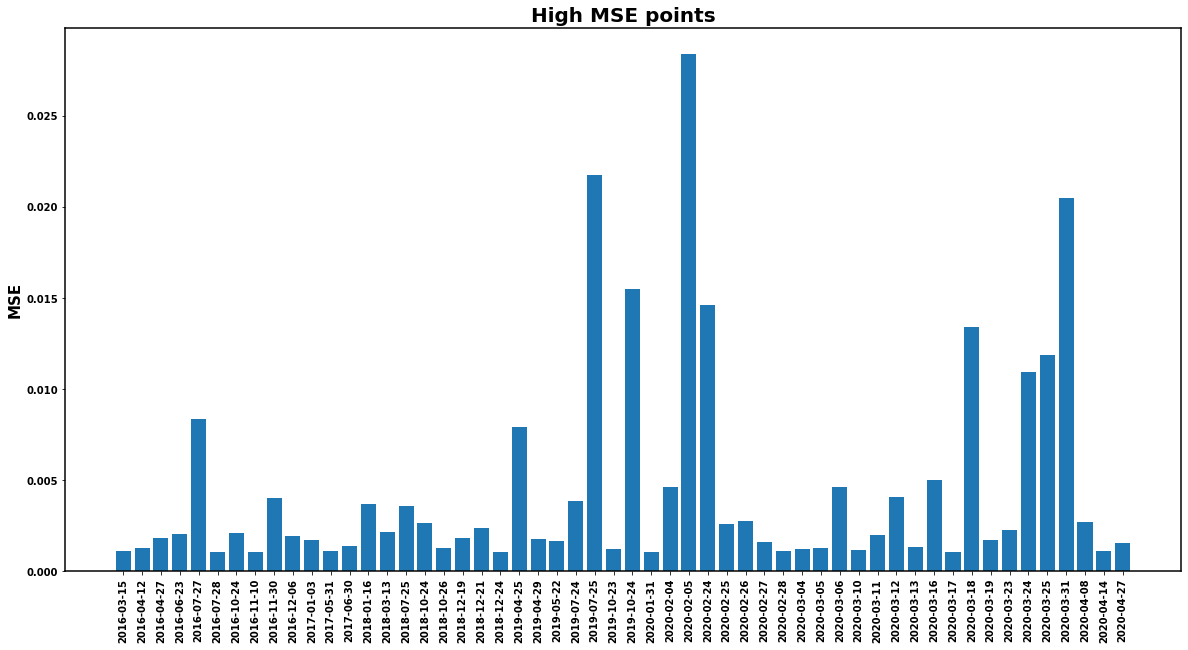

In [242]:
mae(predicted_high,actual_high,np.array(predicted_dates))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))

large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# CNN-LSTM:

In [343]:
# univariate cnn lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import matplotlib.pyplot as plt
%matplotlib inline
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0,pw=2,window_size = window)
print(X_train.shape)
#X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=12, kernel_size=1, activation='relu'), input_shape=(6,1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model

import time
start_time = time.time()

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    
    predicted_high.append(yhat[0])
    predicted_dates.append(Date_test[0])
    actual_high.append(y_test[0])
    model_loss.append(history.history['loss'][-1])
    model_val_loss.append(history.history['val_loss'][-1])
    
time_taken = time.time() - start_time
history = model.fit(X, y, epochs=500, verbose=0)

(200, 6, 1)


ValueError: Input tensor must be of rank 3, 4 or 5 but was 2.

# Long-term Forecasting:

In [256]:
def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)


In [258]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model = tf.keras.models.Sequential()
    
model.add(tf.keras.layers.Reshape((6,),input_shape=(6,)))
    
model.add(tf.keras.layers.Dense(200,activation='relu'))
    
model.add(tf.keras.layers.Dense(1,activation='linear'))
    
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [261]:
X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0,pw=2,window_size = window)
history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
yhat = model.predict(X_test, verbose=0)
print(yhat)

Epoch 00020: early stopping
[[0.7921292]
 [0.8118581]]


In [318]:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=2,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00023: early stopping
1
Epoch 00018: early stopping
2
Epoch 00011: early stopping
3
Epoch 00015: early stopping
4
Epoch 00012: early stopping
5
Epoch 00012: early stopping
6
Epoch 00011: early stopping
7
Epoch 00021: early stopping
8
Epoch 00017: early stopping
9
Epoch 00013: early stopping
10
Epoch 00016: early stopping
11
Epoch 00023: early stopping
12
Epoch 00015: early stopping
13
Epoch 00016: early stopping
14
Epoch 00017: early stopping
15
Epoch 00012: early stopping
16
Epoch 00015: early stopping
17
Epoch 00011: early stopping
18
Epoch 00014: early stopping
19
Epoch 00016: early stopping
20
Epoch 00017: early stopping
21
Epoch 00013: early stopping
22
Epoch 00012: early stopping
23
Epoch 00011: early stopping
24
Epoch 00013: early stopping
25
Epoch 00017: early stopping
26
Epoch 00014: early stopping
27
Epoch 00015: early stopping
28
Epoch 00016: early stopping
29
Epoch 00017: early stopping
30
Epoch 00014: early stopping
31
Epoch 00011: early stopping
32
Epoch 00012: ea

Epoch 00012: early stopping
261
Epoch 00026: early stopping
262
Epoch 00016: early stopping
263
Epoch 00021: early stopping
264
Epoch 00020: early stopping
265
Epoch 00027: early stopping
266
Epoch 00014: early stopping
267
Epoch 00012: early stopping
268
Epoch 00023: early stopping
269
Epoch 00015: early stopping
270
Epoch 00016: early stopping
271
Epoch 00011: early stopping
272
Epoch 00016: early stopping
273
Epoch 00016: early stopping
274
Epoch 00011: early stopping
275
Epoch 00046: early stopping
276
Epoch 00044: early stopping
277
Epoch 00011: early stopping
278
Epoch 00011: early stopping
279
Epoch 00014: early stopping
280
Epoch 00012: early stopping
281
Epoch 00013: early stopping
282
Epoch 00012: early stopping
283
Epoch 00014: early stopping
284
Epoch 00016: early stopping
285
Epoch 00016: early stopping
286
Epoch 00016: early stopping
287
Epoch 00016: early stopping
288
Epoch 00013: early stopping
289
Epoch 00023: early stopping
290
Epoch 00016: early stopping
291
Epoch 00

Epoch 00014: early stopping
519
Epoch 00014: early stopping
520
Epoch 00011: early stopping
521
Epoch 00013: early stopping
522
Epoch 00017: early stopping
523
Epoch 00020: early stopping
524
Epoch 00016: early stopping
525
526
Epoch 00017: early stopping
527
Epoch 00015: early stopping
528
Epoch 00016: early stopping
529
Epoch 00011: early stopping
530
Epoch 00017: early stopping
531
Epoch 00011: early stopping
532
Epoch 00045: early stopping
533
Epoch 00013: early stopping
534
Epoch 00012: early stopping
535
Epoch 00015: early stopping
536
Epoch 00018: early stopping
537
Epoch 00014: early stopping
538
Epoch 00015: early stopping
539
Epoch 00011: early stopping
540
Epoch 00016: early stopping
541
Epoch 00011: early stopping
542
Epoch 00011: early stopping
543
544
Epoch 00015: early stopping
545
Epoch 00014: early stopping
546
Epoch 00012: early stopping
547
Epoch 00014: early stopping
548
Epoch 00014: early stopping
549
Epoch 00011: early stopping
550
Epoch 00011: early stopping
551


777
Epoch 00011: early stopping
778
Epoch 00012: early stopping
779
Epoch 00023: early stopping
780
Epoch 00011: early stopping
781
Epoch 00016: early stopping
782
Epoch 00011: early stopping
783
Epoch 00040: early stopping
784
Epoch 00020: early stopping
785
Epoch 00011: early stopping
786
Epoch 00022: early stopping
787
Epoch 00018: early stopping
788
Epoch 00043: early stopping
789
Epoch 00014: early stopping
790
Epoch 00015: early stopping
791
Epoch 00013: early stopping
792
Epoch 00024: early stopping
793
Epoch 00018: early stopping
794
Epoch 00020: early stopping
795
Epoch 00016: early stopping
796
Epoch 00014: early stopping
797
Epoch 00016: early stopping
798
Epoch 00012: early stopping
799
Epoch 00029: early stopping
800
Epoch 00015: early stopping
801
Epoch 00011: early stopping
802
Epoch 00067: early stopping
803
Epoch 00023: early stopping
804
Epoch 00012: early stopping
805
Epoch 00031: early stopping
806
Epoch 00021: early stopping
807
Epoch 00020: early stopping
808
Epoc

Epoch 00023: early stopping
1034
Epoch 00013: early stopping
1035
Epoch 00027: early stopping
1036
Epoch 00011: early stopping
1037
Epoch 00012: early stopping
1038
Epoch 00011: early stopping
1039
Epoch 00011: early stopping
1040
Epoch 00047: early stopping
1041
Epoch 00054: early stopping
1042
Epoch 00013: early stopping
1043
Epoch 00013: early stopping
1044
Epoch 00011: early stopping
1045
Epoch 00012: early stopping
1046
Epoch 00028: early stopping
1047
Epoch 00011: early stopping
1048
Epoch 00011: early stopping
1049
Epoch 00017: early stopping
1050
Epoch 00020: early stopping
1051
Epoch 00040: early stopping
1052
Epoch 00013: early stopping
1053
Epoch 00012: early stopping
1054
Epoch 00040: early stopping
1055
Epoch 00012: early stopping
1056
Epoch 00056: early stopping
1057
Epoch 00012: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.7990865, 0.8206794261932373, 0.815744936466217, 0.8137502670288086, 0.7884932160377502]
[0.804728546409807

time taken for execution : 253.69977593421936 seconds 
Mean Validation loss= 0.00020743
Mean Model loss= 0.00013457


<BarContainer object of 48 artists>

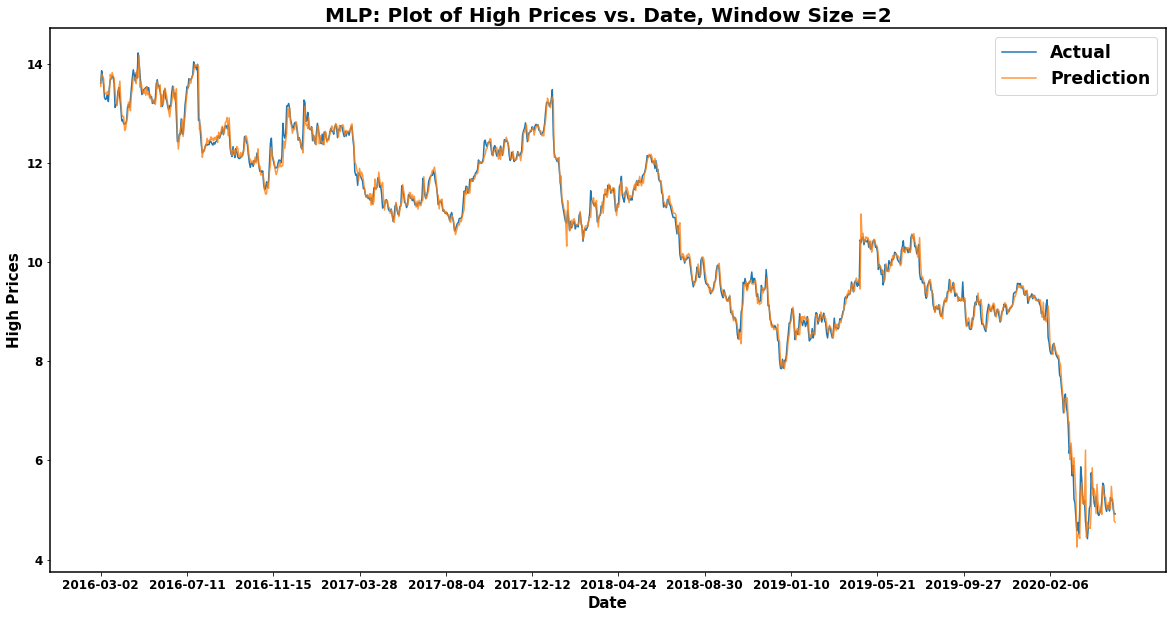

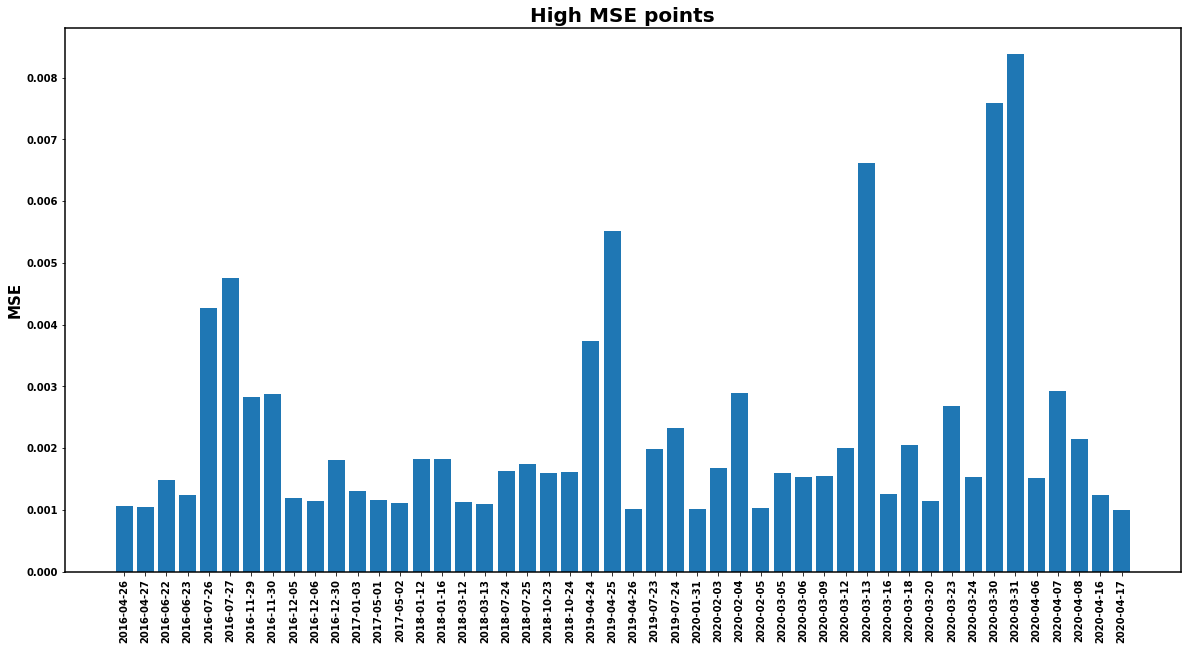

In [321]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('MLP: Plot of High Prices vs. Date, Window Size =2',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    plt.savefig("LSTM.pdf")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

In [322]:
#window size =3:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=2,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00021: early stopping
1
Epoch 00084: early stopping
2
Epoch 00014: early stopping
3
Epoch 00014: early stopping
4
Epoch 00011: early stopping
5
Epoch 00011: early stopping
6
Epoch 00011: early stopping
7
Epoch 00011: early stopping
8
Epoch 00103: early stopping
9
Epoch 00015: early stopping
10
Epoch 00014: early stopping
11
Epoch 00016: early stopping
12
Epoch 00014: early stopping
13
Epoch 00012: early stopping
14
Epoch 00014: early stopping
15
Epoch 00012: early stopping
16
Epoch 00013: early stopping
17
Epoch 00011: early stopping
18
Epoch 00013: early stopping
19
Epoch 00015: early stopping
20
Epoch 00013: early stopping
21
Epoch 00012: early stopping
22
Epoch 00011: early stopping
23
Epoch 00011: early stopping
24
Epoch 00014: early stopping
25
Epoch 00014: early stopping
26
Epoch 00012: early stopping
27
Epoch 00012: early stopping
28
Epoch 00013: early stopping
29
Epoch 00014: early stopping
30
Epoch 00011: early stopping
31
Epoch 00011: early stopping
32
Epoch 00011: ea

Epoch 00017: early stopping
261
Epoch 00011: early stopping
262
Epoch 00030: early stopping
263
Epoch 00012: early stopping
264
Epoch 00018: early stopping
265
Epoch 00013: early stopping
266
Epoch 00013: early stopping
267
Epoch 00015: early stopping
268
Epoch 00015: early stopping
269
Epoch 00013: early stopping
270
Epoch 00013: early stopping
271
Epoch 00011: early stopping
272
Epoch 00022: early stopping
273
Epoch 00023: early stopping
274
Epoch 00012: early stopping
275
Epoch 00019: early stopping
276
Epoch 00024: early stopping
277
Epoch 00018: early stopping
278
Epoch 00029: early stopping
279
Epoch 00024: early stopping
280
Epoch 00013: early stopping
281
Epoch 00015: early stopping
282
Epoch 00024: early stopping
283
Epoch 00022: early stopping
284
Epoch 00016: early stopping
285
Epoch 00021: early stopping
286
Epoch 00018: early stopping
287
Epoch 00016: early stopping
288
Epoch 00020: early stopping
289
Epoch 00019: early stopping
290
Epoch 00015: early stopping
291
Epoch 00

Epoch 00013: early stopping
525
Epoch 00013: early stopping
526
Epoch 00013: early stopping
527
Epoch 00011: early stopping
528
Epoch 00013: early stopping
529
Epoch 00011: early stopping
530
Epoch 00013: early stopping
531
Epoch 00011: early stopping
532
Epoch 00011: early stopping
533
Epoch 00012: early stopping
534
Epoch 00018: early stopping
535
Epoch 00014: early stopping
536
Epoch 00014: early stopping
537
Epoch 00013: early stopping
538
Epoch 00014: early stopping
539
Epoch 00011: early stopping
540
Epoch 00014: early stopping
541
Epoch 00011: early stopping
542
Epoch 00011: early stopping
543
Epoch 00011: early stopping
544
Epoch 00013: early stopping
545
Epoch 00013: early stopping
546
Epoch 00011: early stopping
547
Epoch 00013: early stopping
548
Epoch 00013: early stopping
549
Epoch 00011: early stopping
550
Epoch 00011: early stopping
551
Epoch 00011: early stopping
552
Epoch 00011: early stopping
553
554
Epoch 00011: early stopping
555
Epoch 00011: early stopping
556
Epoc

Epoch 00012: early stopping
796
Epoch 00014: early stopping
797
Epoch 00011: early stopping
798
Epoch 00012: early stopping
799
Epoch 00011: early stopping
800
Epoch 00012: early stopping
801
Epoch 00011: early stopping
802
Epoch 00026: early stopping
803
Epoch 00012: early stopping
804
Epoch 00012: early stopping
805
Epoch 00049: early stopping
806
Epoch 00038: early stopping
807
Epoch 00012: early stopping
808
Epoch 00011: early stopping
809
Epoch 00056: early stopping
810
Epoch 00012: early stopping
811
Epoch 00083: early stopping
812
Epoch 00012: early stopping
813
Epoch 00016: early stopping
814
Epoch 00022: early stopping
815
Epoch 00106: early stopping
816
Epoch 00012: early stopping
817
Epoch 00012: early stopping
818
Epoch 00011: early stopping
819
Epoch 00012: early stopping
820
Epoch 00012: early stopping
821
Epoch 00012: early stopping
822
Epoch 00011: early stopping
823
Epoch 00011: early stopping
824
Epoch 00037: early stopping
825
Epoch 00058: early stopping
826
Epoch 00

Epoch 00012: early stopping
1054
Epoch 00026: early stopping
1055
Epoch 00012: early stopping
1056
Epoch 00013: early stopping
1057
Epoch 00038: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.7823787, 0.8095200061798096, 0.8116406202316284, 0.8122562170028687, 0.7834798097610474]
[0.8047285464098073, 0.8266199649737302, 0.8161120840630474, 0.8021015761821366, 0.7793345008756569]


time taken for execution : 302.8829839229584 seconds 
Mean Validation loss= 0.00018256
Mean Model loss= 0.00013391


<BarContainer object of 33 artists>

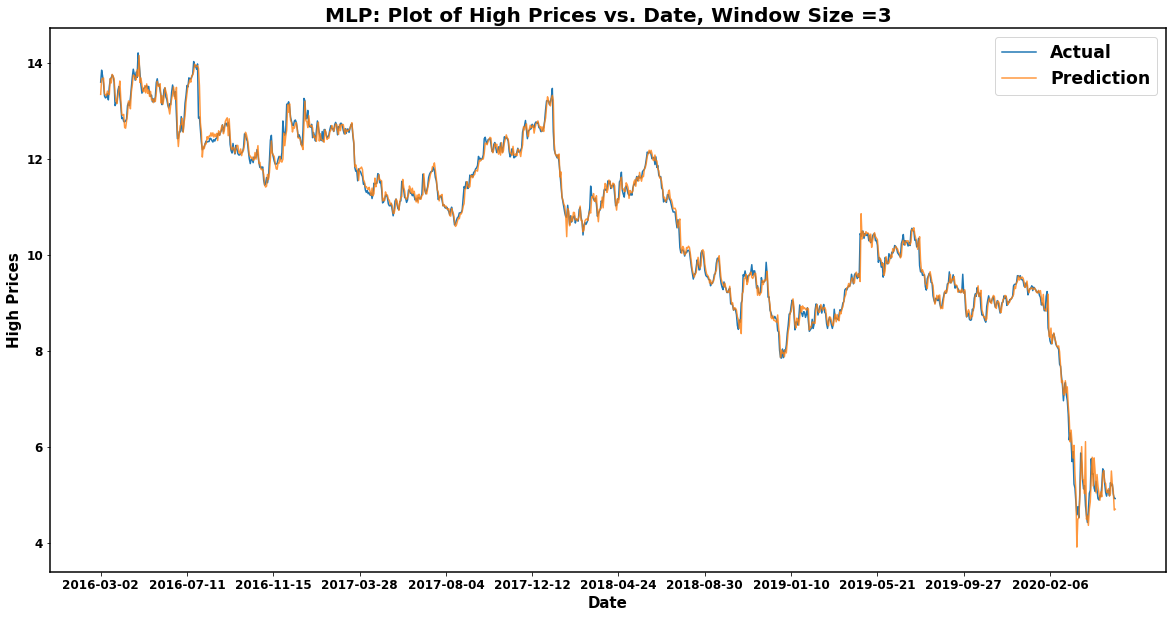

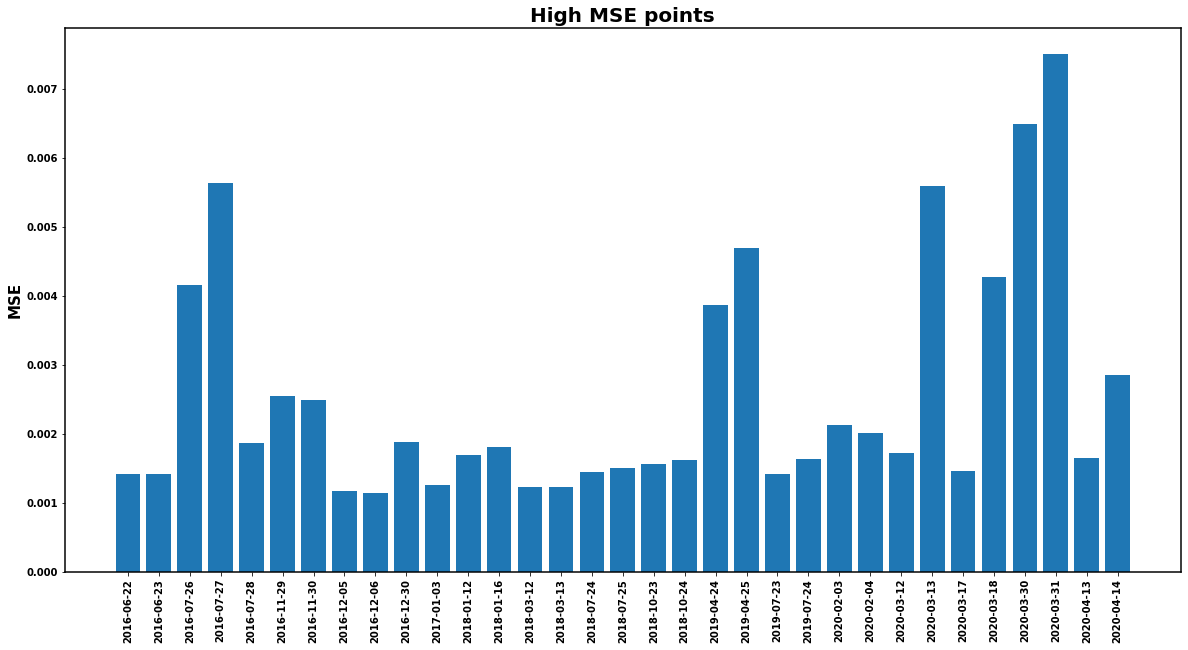

In [324]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('MLP: Plot of High Prices vs. Date, Window Size =3',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    plt.savefig("LSTM.pdf")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

In [325]:
#window size =5:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=5,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00016: early stopping
1
Epoch 00068: early stopping
2
Epoch 00012: early stopping
3
Epoch 00013: early stopping
4
Epoch 00011: early stopping
5
Epoch 00011: early stopping
6
Epoch 00011: early stopping
7
Epoch 00011: early stopping
8
Epoch 00044: early stopping
9
Epoch 00013: early stopping
10
Epoch 00011: early stopping
11
Epoch 00011: early stopping
12
Epoch 00013: early stopping
13
Epoch 00012: early stopping
14
Epoch 00199: early stopping
15
Epoch 00013: early stopping
16
Epoch 00012: early stopping
17
Epoch 00015: early stopping
18
Epoch 00011: early stopping
19
Epoch 00015: early stopping
20
Epoch 00013: early stopping
21
Epoch 00012: early stopping
22
Epoch 00028: early stopping
23
Epoch 00013: early stopping
24
Epoch 00011: early stopping
25
Epoch 00014: early stopping
26
Epoch 00012: early stopping
27
Epoch 00011: early stopping
28
Epoch 00013: early stopping
29
Epoch 00011: early stopping
30
Epoch 00011: early stopping
31
Epoch 00011: early stopping
32
Epoch 00011: ea

Epoch 00022: early stopping
263
Epoch 00014: early stopping
264
Epoch 00046: early stopping
265
Epoch 00015: early stopping
266
Epoch 00013: early stopping
267
Epoch 00011: early stopping
268
Epoch 00038: early stopping
269
Epoch 00012: early stopping
270
Epoch 00012: early stopping
271
Epoch 00066: early stopping
272
Epoch 00031: early stopping
273
Epoch 00122: early stopping
274
Epoch 00011: early stopping
275
276
Epoch 00013: early stopping
277
Epoch 00012: early stopping
278
Epoch 00011: early stopping
279
Epoch 00012: early stopping
280
Epoch 00011: early stopping
281
Epoch 00011: early stopping
282
Epoch 00023: early stopping
283
Epoch 00012: early stopping
284
Epoch 00012: early stopping
285
Epoch 00011: early stopping
286
Epoch 00012: early stopping
287
Epoch 00032: early stopping
288
Epoch 00012: early stopping
289
Epoch 00013: early stopping
290
Epoch 00012: early stopping
291
Epoch 00011: early stopping
292
Epoch 00012: early stopping
293
Epoch 00013: early stopping
294
Epoc

Epoch 00013: early stopping
527
Epoch 00012: early stopping
528
Epoch 00013: early stopping
529
Epoch 00011: early stopping
530
Epoch 00013: early stopping
531
Epoch 00011: early stopping
532
Epoch 00014: early stopping
533
Epoch 00011: early stopping
534
Epoch 00032: early stopping
535
Epoch 00014: early stopping
536
Epoch 00014: early stopping
537
Epoch 00014: early stopping
538
Epoch 00013: early stopping
539
Epoch 00011: early stopping
540
Epoch 00016: early stopping
541
Epoch 00011: early stopping
542
Epoch 00013: early stopping
543
Epoch 00013: early stopping
544
Epoch 00013: early stopping
545
Epoch 00012: early stopping
546
Epoch 00011: early stopping
547
Epoch 00011: early stopping
548
Epoch 00016: early stopping
549
Epoch 00011: early stopping
550
Epoch 00011: early stopping
551
Epoch 00011: early stopping
552
Epoch 00011: early stopping
553
Epoch 00143: early stopping
554
Epoch 00033: early stopping
555
Epoch 00013: early stopping
556
Epoch 00014: early stopping
557
Epoch 00

Epoch 00012: early stopping
787
Epoch 00012: early stopping
788
789
Epoch 00036: early stopping
790
Epoch 00012: early stopping
791
Epoch 00019: early stopping
792
Epoch 00012: early stopping
793
Epoch 00061: early stopping
794
Epoch 00012: early stopping
795
Epoch 00031: early stopping
796
Epoch 00011: early stopping
797
Epoch 00011: early stopping
798
Epoch 00012: early stopping
799
Epoch 00033: early stopping
800
Epoch 00015: early stopping
801
Epoch 00011: early stopping
802
Epoch 00013: early stopping
803
Epoch 00012: early stopping
804
Epoch 00013: early stopping
805
806
Epoch 00012: early stopping
807
Epoch 00012: early stopping
808
Epoch 00011: early stopping
809
Epoch 00011: early stopping
810
Epoch 00012: early stopping
811
Epoch 00042: early stopping
812
Epoch 00011: early stopping
813
Epoch 00142: early stopping
814
Epoch 00021: early stopping
815
Epoch 00019: early stopping
816
Epoch 00011: early stopping
817
Epoch 00012: early stopping
818
Epoch 00020: early stopping
819


Epoch 00026: early stopping
1049
Epoch 00126: early stopping
1050
Epoch 00012: early stopping
1051
Epoch 00035: early stopping
1052
Epoch 00021: early stopping
1053
Epoch 00015: early stopping
1054
Epoch 00036: early stopping
1055
Epoch 00033: early stopping
1056
Epoch 00060: early stopping
1057
Epoch 00012: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.780924, 0.8088845610618591, 0.8134393692016602, 0.8152902871370316, 0.7862624675035477]
[0.8047285464098073, 0.8266199649737302, 0.8161120840630474, 0.8021015761821366, 0.7793345008756569]


time taken for execution : 308.3092119693756 seconds 
Mean Validation loss= 0.00016578
Mean Model loss= 0.00013599


<BarContainer object of 28 artists>

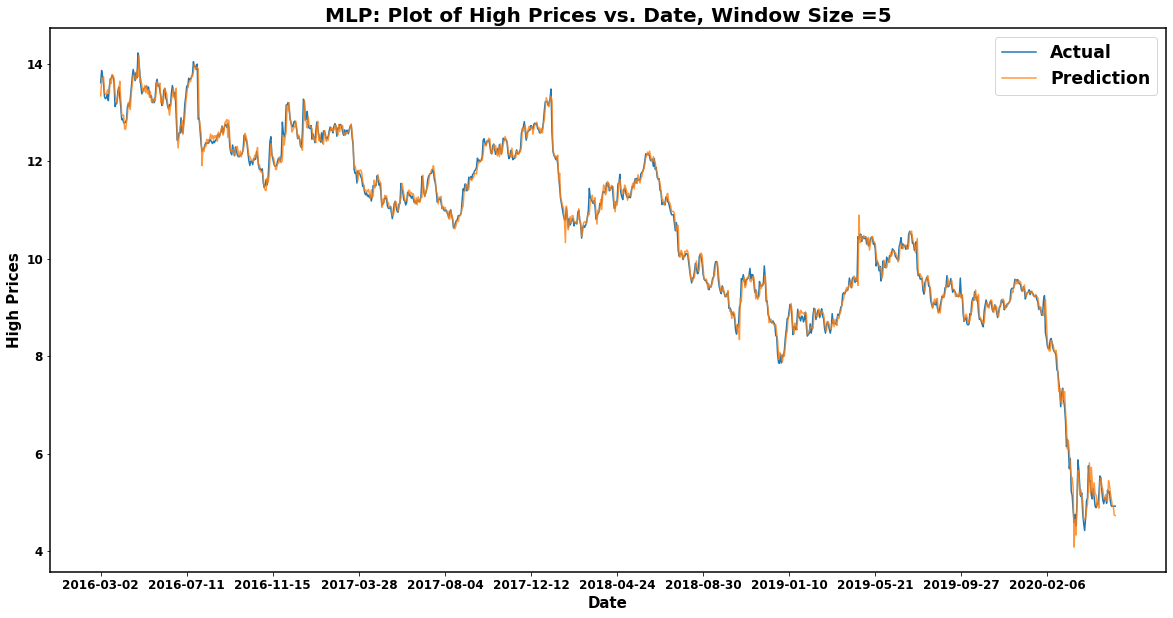

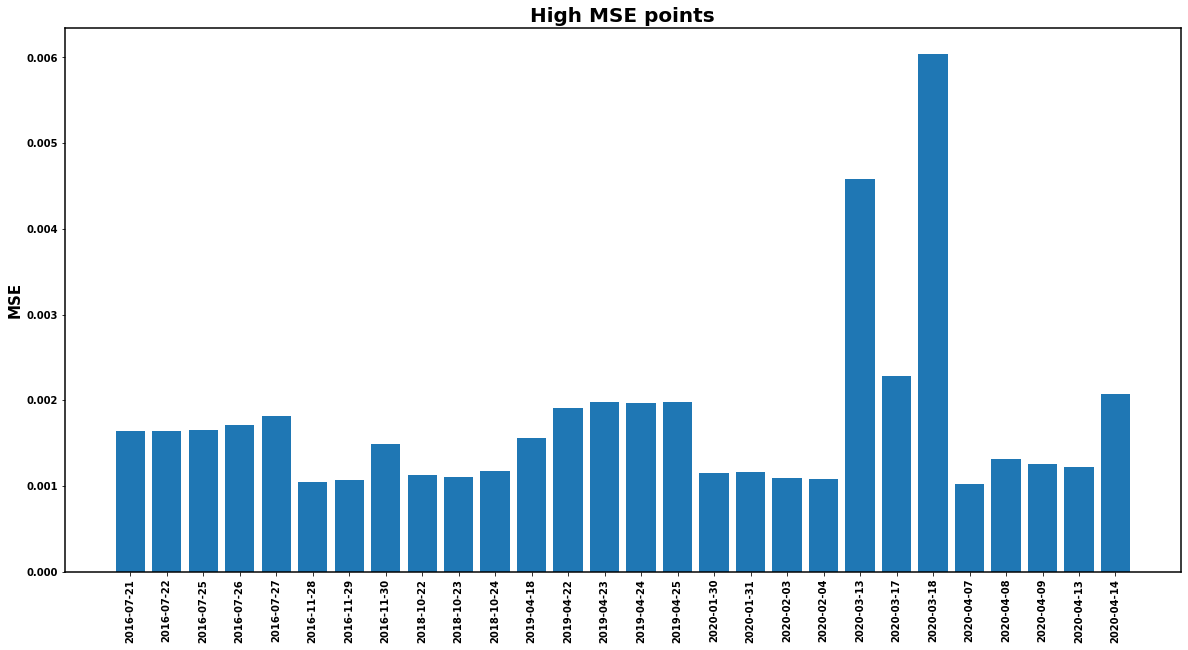

In [326]:
#window size =3:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=2,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

In [344]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)

In [345]:
#window size =5:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=5,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00018: early stopping
1
Epoch 00112: early stopping
2
Epoch 00020: early stopping
3
Epoch 00011: early stopping
4
Epoch 00015: early stopping
5
Epoch 00015: early stopping
6
Epoch 00011: early stopping
7
Epoch 00016: early stopping
8
Epoch 00011: early stopping
9
Epoch 00017: early stopping
10
Epoch 00015: early stopping
11
Epoch 00012: early stopping
12
Epoch 00012: early stopping
13
Epoch 00011: early stopping
14
15
Epoch 00017: early stopping
16
Epoch 00017: early stopping
17
Epoch 00011: early stopping
18
Epoch 00019: early stopping
19
20
Epoch 00015: early stopping
21
22
Epoch 00016: early stopping
23
Epoch 00016: early stopping
24
Epoch 00011: early stopping
25
Epoch 00016: early stopping
26
Epoch 00016: early stopping
27
Epoch 00016: early stopping
28
Epoch 00017: early stopping
29
Epoch 00012: early stopping
30
Epoch 00076: early stopping
31
Epoch 00015: early stopping
32
Epoch 00011: early stopping
33
Epoch 00015: early stopping
34
Epoch 00013: early stopping
35
Epoch 

Epoch 00030: early stopping
263
Epoch 00013: early stopping
264
Epoch 00046: early stopping
265
Epoch 00015: early stopping
266
Epoch 00039: early stopping
267
Epoch 00021: early stopping
268
Epoch 00017: early stopping
269
Epoch 00017: early stopping
270
Epoch 00012: early stopping
271
Epoch 00038: early stopping
272
Epoch 00017: early stopping
273
Epoch 00021: early stopping
274
Epoch 00017: early stopping
275
Epoch 00012: early stopping
276
Epoch 00054: early stopping
277
Epoch 00019: early stopping
278
Epoch 00024: early stopping
279
Epoch 00020: early stopping
280
Epoch 00027: early stopping
281
Epoch 00020: early stopping
282
Epoch 00024: early stopping
283
Epoch 00013: early stopping
284
Epoch 00024: early stopping
285
Epoch 00039: early stopping
286
Epoch 00013: early stopping
287
Epoch 00023: early stopping
288
Epoch 00011: early stopping
289
Epoch 00026: early stopping
290
Epoch 00011: early stopping
291
Epoch 00012: early stopping
292
Epoch 00015: early stopping
293
Epoch 00

Epoch 00041: early stopping
520
Epoch 00011: early stopping
521
Epoch 00038: early stopping
522
Epoch 00038: early stopping
523
Epoch 00017: early stopping
524
Epoch 00035: early stopping
525
Epoch 00014: early stopping
526
Epoch 00027: early stopping
527
Epoch 00038: early stopping
528
Epoch 00025: early stopping
529
Epoch 00056: early stopping
530
Epoch 00024: early stopping
531
Epoch 00018: early stopping
532
Epoch 00039: early stopping
533
Epoch 00014: early stopping
534
Epoch 00041: early stopping
535
Epoch 00011: early stopping
536
Epoch 00041: early stopping
537
Epoch 00012: early stopping
538
Epoch 00011: early stopping
539
Epoch 00026: early stopping
540
Epoch 00014: early stopping
541
Epoch 00032: early stopping
542
Epoch 00015: early stopping
543
Epoch 00017: early stopping
544
Epoch 00011: early stopping
545
Epoch 00020: early stopping
546
Epoch 00013: early stopping
547
Epoch 00048: early stopping
548
Epoch 00013: early stopping
549
Epoch 00030: early stopping
550
Epoch 00

Epoch 00014: early stopping
777
Epoch 00026: early stopping
778
Epoch 00012: early stopping
779
Epoch 00032: early stopping
780
Epoch 00012: early stopping
781
Epoch 00028: early stopping
782
Epoch 00016: early stopping
783
Epoch 00012: early stopping
784
Epoch 00039: early stopping
785
Epoch 00012: early stopping
786
Epoch 00043: early stopping
787
Epoch 00012: early stopping
788
Epoch 00045: early stopping
789
Epoch 00023: early stopping
790
Epoch 00019: early stopping
791
Epoch 00011: early stopping
792
Epoch 00018: early stopping
793
Epoch 00012: early stopping
794
Epoch 00024: early stopping
795
Epoch 00011: early stopping
796
Epoch 00064: early stopping
797
Epoch 00014: early stopping
798
Epoch 00013: early stopping
799
Epoch 00033: early stopping
800
Epoch 00014: early stopping
801
Epoch 00024: early stopping
802
Epoch 00036: early stopping
803
Epoch 00011: early stopping
804
Epoch 00011: early stopping
805
Epoch 00020: early stopping
806
Epoch 00012: early stopping
807
Epoch 00

Epoch 00018: early stopping
1033
Epoch 00065: early stopping
1034
Epoch 00022: early stopping
1035
Epoch 00018: early stopping
1036
Epoch 00011: early stopping
1037
Epoch 00016: early stopping
1038
Epoch 00013: early stopping
1039
Epoch 00013: early stopping
1040
Epoch 00012: early stopping
1041
Epoch 00023: early stopping
1042
Epoch 00015: early stopping
1043
Epoch 00020: early stopping
1044
Epoch 00013: early stopping
1045
Epoch 00016: early stopping
1046
Epoch 00030: early stopping
1047
Epoch 00014: early stopping
1048
Epoch 00024: early stopping
1049
Epoch 00012: early stopping
1050
Epoch 00013: early stopping
1051
Epoch 00013: early stopping
1052
Epoch 00021: early stopping
1053
Epoch 00040: early stopping
1054
Epoch 00011: early stopping
1055
Epoch 00026: early stopping
1056
Epoch 00011: early stopping
1057
Epoch 00011: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.8073855, 0.8121448755264282, 0.8148597478866577, 0.8050403147935867, 0.78

In [ ]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('MLP: Plot of High Prices vs. Date, Window Size =5',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    plt.savefig("LSTM.pdf")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

In [1]:
from sympy.physics.mechanics import dynamicsymbols
from sympy.tensor.array import Array
from simupy.systems.symbolic import DynamicalSystem

x = x1, x2, x3 = Array(dynamicsymbols('x1:4'))
u = dynamicsymbols('u')
sys = DynamicalSystem(Array([-x1+x2-x3, -x1*x2-x2+u, -x1+u]), x, u)

In [3]:
pip install simupy 


     |████████████████████████████████| 182 kB 3.4 MB/s eta 0:00:01
  Created wheel for simupy: filename=simupy-1.0.0-py3-none-any.whl size=25594 sha256=b6ac2363c403a775a2e2e2e16b3e1484c1ed660361c314dea9cedf69147e8c11
  Stored in directory: /Users/aleenaalex/Library/Caches/pip/wheels/07/ba/bd/eaa5b0fac44f99bc4faf1c5b4e830004d42fe821abe0eeac27
Successfully built simupy
You should consider upgrading via the '/Users/aleenaalex/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
sys